In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import functions as fun
plt.rcParams['figure.figsize'] = [20, 10]

store_df = pd.read_csv('data/store.csv')
train_df = pd.read_csv('data/train.csv')

In [49]:
print(store_df.isnull().sum())
print(train_df.isnull().sum())

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64
Date                 0
Store            19301
DayOfWeek        19017
Sales            19027
Customers        19091
Open             19186
Promo            19194
StateHoliday     19254
SchoolHoliday    19337
dtype: int64


In [50]:
#
# CLEANING STORE DATA
#

# Promo2SinceWeek, Promo2SinceYear, PromoInterval are only NaN when Promo2 is 0, so it's not a problem:
print(store_df.loc[(store_df['Promo2'] == 0) & 
                   ~pd.isna(store_df['Promo2SinceWeek']) & 
                   ~pd.isna(store_df['Promo2SinceYear']) & 
                   ~pd.isna(store_df['PromoInterval'])].empty)

# We fill the competition dates with our firs day of data:
store_df_clean = store_df.fillna({'CompetitionOpenSinceYear':2013.0})
store_df_clean = store_df_clean.fillna({'CompetitionOpenSinceMonth':1.0})

#store_df_clean.head(50)

True


In [51]:
# There are 3 NaN spaces with in 'CompetitionDistance':
store_df_clean.loc[pd.isna(store_df_clean['CompetitionDistance'])].head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,1.0,2013.0,0,NaN,NaN,NaN
621,622,a,c,NaN,1.0,2013.0,0,NaN,NaN,NaN
878,879,d,a,NaN,1.0,2013.0,1,5.0,2013.0,"Feb,May,Aug,Nov"


/home/mat/anaconda3/envs/mini-comp/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mat/anaconda3/envs/mini-comp/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


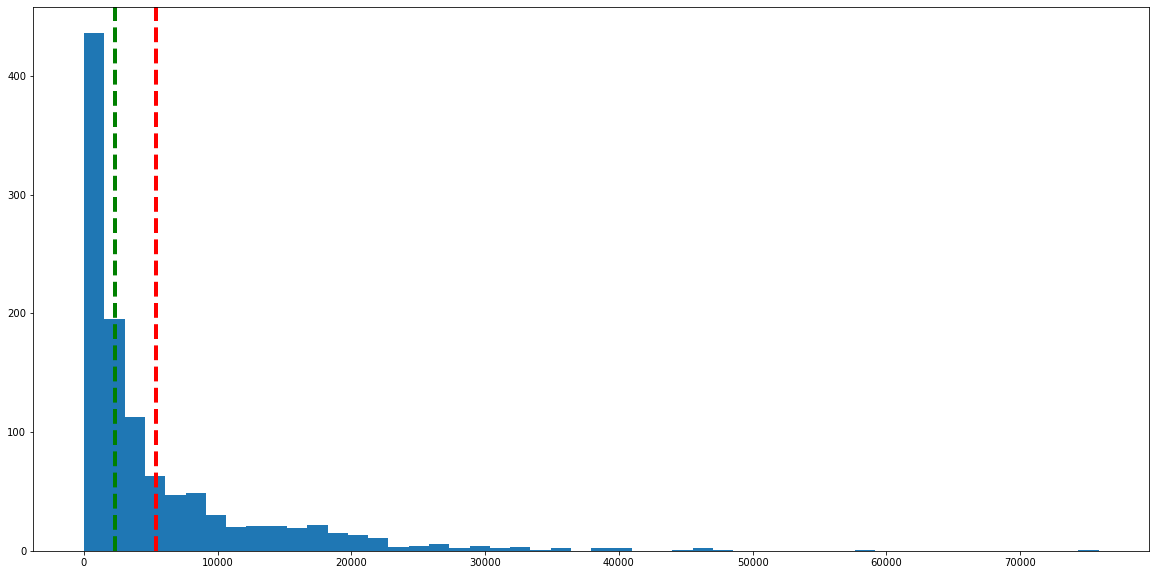

In [52]:
# Plotting distribution, mean and median to see which value we could use to fill the gaps: 
mean = store_df_clean["CompetitionDistance"].mean(axis=0)
median = store_df_clean["CompetitionDistance"].median(axis=0)
plt.hist(store_df_clean["CompetitionDistance"], bins=50)
plt.axvline(mean, color='r', linestyle='dashed', linewidth=4)
plt.axvline(median, color='g', linestyle='dashed', linewidth=4)

# Seems like median is a reasonable value to fill those NaN spaces:
store_df_clean = store_df_clean.fillna({'CompetitionDistance':median})

In [53]:
#
# MERGE TRAIN AND STORE DATA AND CLEAN
#

df = fun.merge_files(train_df, store_df_clean)
df.loc[df['Date'] == '2013-01-21'].head(50)

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
22299,2013-01-21,367.0,1.0,8161.0,693.0,1.0,1.0,0,0.0,d,c,2640.0,9.0,2012.0,0.0,NaN,NaN,NaN
22300,2013-01-21,368.0,1.0,11370.0,736.0,1.0,1.0,0,0.0,d,c,1450.0,4.0,2005.0,1.0,45.0,2009.0,"Feb,May,Aug,Nov"
22301,2013-01-21,369.0,1.0,5803.0,443.0,1.0,1.0,0,0.0,d,c,5870.0,4.0,2014.0,0.0,NaN,NaN,NaN
22302,2013-01-21,370.0,1.0,5107.0,411.0,1.0,1.0,0,0.0,d,a,8250.0,10.0,2000.0,1.0,31.0,2009.0,"Jan,Apr,Jul,Oct"
22303,2013-01-21,NaN,1.0,4294.0,479.0,1.0,1.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22304,2013-01-21,371.0,1.0,5634.0,431.0,1.0,1.0,0,0.0,d,c,1970.0,7.0,2009.0,1.0,45.0,2014.0,"Feb,May,Aug,Nov"
22305,2013-01-21,374.0,1.0,8794.0,951.0,1.0,1.0,0,0.0,a,a,1150.0,9.0,2007.0,0.0,NaN,NaN,NaN
22306,2013-01-21,373.0,1.0,4305.0,308.0,1.0,1.0,0,0.0,d,c,11120.0,1.0,2013.0,1.0,22.0,2012.0,"Jan,Apr,Jul,Oct"
22307,2013-01-21,375.0,NaN,11004.0,861.0,1.0,1.0,0,0.0,a,c,15710.0,2.0,2013.0,1.0,37.0,2009.0,"Jan,Apr,Jul,Oct"
22308,2013-01-21,376.0,1.0,11739.0,1230.0,1.0,1.0,0,0.0,a,a,160.0,8.0,2012.0,0.0,NaN,NaN,NaN


In [54]:
print(df.isnull().sum())

Date                              0
Store                         19301
DayOfWeek                     19017
Sales                         19027
Customers                     19091
Open                          19186
Promo                         19194
StateHoliday                  19254
SchoolHoliday                 19337
StoreType                     19301
Assortment                    19301
CompetitionDistance           19301
CompetitionOpenSinceMonth     19301
CompetitionOpenSinceYear      19301
Promo2                        19301
Promo2SinceWeek              322946
Promo2SinceYear              322946
PromoInterval                322946
dtype: int64


In [55]:
# Convert Date column to DateTime
df2 = df
df2['Date'] = pd.to_datetime(df2['Date'])
df2.head(50)

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2013-01-01,1115.0,2.0,0.0,0.0,0.0,0.0,a,1.0,d,c,5350.0,1.0,2013.0,1.0,22.0,2012.0,"Mar,Jun,Sept,Dec"
1,2013-01-01,379.0,2.0,0.0,0.0,0.0,0.0,a,1.0,d,a,6630.0,1.0,2013.0,0.0,NaN,NaN,NaN
2,2013-01-01,378.0,2.0,0.0,0.0,0.0,0.0,a,1.0,a,c,2140.0,8.0,2012.0,0.0,NaN,NaN,NaN
3,2013-01-01,377.0,2.0,0.0,0.0,0.0,0.0,a,1.0,a,c,100.0,6.0,2010.0,1.0,18.0,2010.0,"Feb,May,Aug,Nov"
4,2013-01-01,376.0,2.0,0.0,0.0,0.0,0.0,a,1.0,a,a,160.0,8.0,2012.0,0.0,NaN,NaN,NaN
5,2013-01-01,375.0,2.0,0.0,0.0,0.0,0.0,a,1.0,a,c,15710.0,2.0,2013.0,1.0,37.0,2009.0,"Jan,Apr,Jul,Oct"
6,2013-01-01,374.0,2.0,0.0,0.0,0.0,0.0,a,1.0,a,a,1150.0,9.0,2007.0,0.0,NaN,NaN,NaN
7,2013-01-01,373.0,2.0,0.0,0.0,0.0,0.0,a,1.0,d,c,11120.0,1.0,2013.0,1.0,22.0,2012.0,"Jan,Apr,Jul,Oct"
8,2013-01-01,372.0,2.0,0.0,0.0,0.0,NaN,a,1.0,d,c,4880.0,8.0,2010.0,1.0,18.0,2014.0,"Jan,Apr,Jul,Oct"
9,2013-01-01,371.0,2.0,0.0,0.0,0.0,0.0,a,1.0,d,c,1970.0,7.0,2009.0,1.0,45.0,2014.0,"Feb,May,Aug,Nov"


In [56]:
# Set NaN values on 'DayOfWeek', 'StateHoliday' and 'SchoolHoliday' to the mode of the same day (most common value of all stores)

ids = pd.isnull(df2['DayOfWeek'])
df3 = df2
for i in range(df3.shape[0]):
    if pd.isna(df3['DayOfWeek'].iloc[i]):
        date = df3['Date'].iloc[i]
        mode = df3['DayOfWeek'].loc[df3['Date'] == date].mode()
        df3['DayOfWeek'].iloc[i] = mode[0]
    if pd.isna(df3['StateHoliday'].iloc[i]):
        date = df3['Date'].iloc[i]
        mode = df3['StateHoliday'].loc[df3['Date'] == date].mode()
        df3['StateHoliday'].iloc[i] = mode[0]
    if pd.isna(df3['SchoolHoliday'].iloc[i]):
        date = df3['Date'].iloc[i]
        mode = df3['SchoolHoliday'].loc[df3['Date'] == date].mode()
        df3['SchoolHoliday'].iloc[i] = mode[0]
    
#df3.head(50)

/home/mat/anaconda3/envs/mini-comp/lib/python3.6/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [57]:
# Save
df3.to_pickle('data/clean_data.pkl')

In [58]:
# Load to check that it's fine and print data for a single store
df4 = pd.read_pickle('data/clean_data.pkl')
#df4.loc[df['Store'] == 330].head(50)

In [59]:
# Check if there are days with customers but no sales, and vice-versa.
print(df4.loc[(df4['Customers'] == 0) & ~(df4['Sales'] == 0) & ~pd.isna(df4['Sales'])].empty)
df4.loc[(df4['Sales'] == 0) & ~(df4['Customers'] == 0) & ~pd.isna(df4['Customers'])].head()

# There are some sales with no customer, but we found out this isn't a problem because we will delete rows without sales

True


,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
127723,2013-04-25,NaN,4.0,0.0,5.0,1.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
539292,2014-04-29,1100.0,2.0,0.0,3.0,1.0,NaN,0,0.0,a,a,540.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [60]:
# Fill NaN 'Promo' as 0:
df5 = df4.fillna({'Promo':0})

In [61]:
# Remove all rows with Sales = 0 (don't matter for the model):
df6 = df5.drop(df4["Sales"].loc[df4["Sales"]==0].index)

#df5.head(50)

In [62]:
df6.isnull().sum()

Date                              0
Store                         16162
DayOfWeek                         0
Sales                         19027
Customers                     16023
Open                          16019
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                     16162
Assortment                    16162
CompetitionDistance           16162
CompetitionOpenSinceMonth     16162
CompetitionOpenSinceYear      16162
Promo2                        16162
Promo2SinceWeek              270276
Promo2SinceYear              270276
PromoInterval                270276
dtype: int64

In [93]:
#print(df6.loc[       (df6["Date"] == '2013-01-01')       &        (df6["Store"] == 414) ])
print(df6['Store'].loc[       (df6['Date'] == datetime.date(2013,1,1)) ] )
#print(df6.loc[df6["Date"] == "2013-01-01"] + timedelta(days=14))
#print(df6.loc[df6["Date"] == "2013-01-01"] + timedelta(days=21))
print(df6[0].loc[df6['Date'] == datetime.date(2013,1,1)])

Series([], Name: Store, dtype: float64)
Empty DataFrame
Columns: [Date, Store, DayOfWeek, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday, StoreType, Assortment, CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2, Promo2SinceWeek, Promo2SinceYear, PromoInterval]
Index: []


In [64]:
df6.to_pickle('data/clean_data.pkl')

In [212]:
target_row = df6.loc[(df6.Date=='2013-04-18') & (df6.Store==271)]
target_store = target_row.iloc[0, 1]
target_date = target_row.iloc[0, 0]

In [213]:
target_date

Timestamp('2013-04-18 00:00:00')

In [199]:
target_store_df = df6.loc[df6['Store']==target_row.iloc[0,1]]
df_filtered_weekday = target_store_df.loc[target_store_df['DayOfWeek']==target_row.iloc[0,2]]
df_filtered_weekday2 = df_filtered_weekday.reset_index()
idx_target = df_filtered_weekday2.loc[df_filtered_weekday2.Date == target_row.iloc[0,0]].index.tolist()[0]
mean = df_filtered_weekday2.iloc[idx_target-4:idx_target]['Sales'].mean()
df_filtered_weekday2.head(50)
#df_filtered_weekday.iloc[idx_target]

,index,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2686,2013-01-03,271.0,4.0,5800.0,760.0,1.0,0.0,0,0.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
1,10493,2013-01-10,271.0,4.0,9341.0,982.0,1.0,1.0,0,0.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,18296,2013-01-17,271.0,4.0,4758.0,642.0,1.0,0.0,0,0.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,26103,2013-01-24,271.0,4.0,8785.0,895.0,1.0,1.0,0,0.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
4,33906,2013-01-31,271.0,4.0,6909.0,818.0,1.0,0.0,0,0.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
5,41713,2013-02-07,271.0,4.0,8653.0,903.0,1.0,1.0,0,1.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
6,49516,2013-02-14,271.0,4.0,5957.0,729.0,1.0,0.0,0,1.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
7,57323,2013-02-21,271.0,4.0,8267.0,823.0,1.0,1.0,0,0.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
8,65127,2013-02-28,271.0,4.0,7350.0,873.0,1.0,0.0,0,0.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
9,72931,2013-03-07,271.0,4.0,9618.0,1001.0,1.0,1.0,0,0.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [194]:
df6['Sales'].loc[df6['Store']==target_store & df6['Store']==target_store]

/home/mat/anaconda3/envs/mini-comp/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [195]:
df_filtered_weekday2.head(50)


,index,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,2686,2013-01-03,271.0,4.0,5800.0,760.0,1.0,0.0,0,0.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
1,10493,2013-01-10,271.0,4.0,9341.0,982.0,1.0,1.0,0,0.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,18296,2013-01-17,271.0,4.0,4758.0,642.0,1.0,0.0,0,0.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,26103,2013-01-24,271.0,4.0,8785.0,895.0,1.0,1.0,0,0.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
4,33906,2013-01-31,271.0,4.0,6909.0,818.0,1.0,0.0,0,0.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
5,41713,2013-02-07,271.0,4.0,8653.0,903.0,1.0,1.0,0,1.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
6,49516,2013-02-14,271.0,4.0,5957.0,729.0,1.0,0.0,0,1.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
7,57323,2013-02-21,271.0,4.0,8267.0,823.0,1.0,1.0,0,0.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
8,65127,2013-02-28,271.0,4.0,7350.0,873.0,1.0,0.0,0,0.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
9,72931,2013-03-07,271.0,4.0,9618.0,1001.0,1.0,1.0,0,0.0,a,a,420.0,1.0,2013.0,1.0,14.0,2011.0,"Jan,Apr,Jul,Oct"
